In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl

In [4]:
%matplotlib inline

In [5]:
mpl.rcParams['font.size'] = 16.
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['axes.labelsize'] = 10.
mpl.rcParams['xtick.labelsize'] = 12.
mpl.rcParams['ytick.labelsize'] = 12.

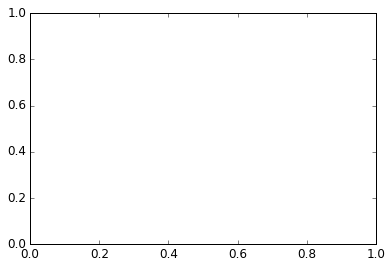

In [6]:
fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])

In [20]:
lllat = 25; urlat = 37; lllon = -107; urlon = -93

(862,
 5,
 [-106.645646, 25.837163999999998, 0.0, 0.0],
 [-93.508039, 36.500704, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x13749f630>)

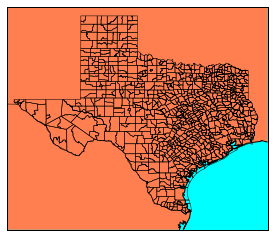

In [26]:
map = Basemap(lon_0=(urlon+lllon)/2, lat_0=(urlat+lllat)/2, 
            llcrnrlat=lllat, urcrnrlat=urlat,llcrnrlon=lllon,urcrnrlon=urlon,resolution='l')
map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='coral',lake_color='aqua')
map.drawcoastlines()
map.drawcountries()
map.readshapefile('./tl_2013_48_cousub/tl_2013_48_cousub', 'counties')